## Work
1. 請嘗試將 preproc_x 替換成以每筆資料的 min/max 進行標準化至 -1 ~ 1 間，再進行訓練
2. 請嘗試將 mlp 疊更深 (e.g 5~10 層)，進行訓練後觀察 learning curve 的走勢
3. (optional) 請改用 GPU 進行訓練 (如果你有 GPU 的話)，比較使用 CPU 與 GPU 的訓練速度        

In [1]:
## 確認硬體資源 (僅適用於 mac / linux)
# !nvidia-smi

In [2]:
import os
import keras
import numpy as np

# 防止調用 GPU 報錯：Blas GEMM launch failed
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allocator_type = 'BFC' #A "Best-fit with coalescing" algorithm, simplified from a version of dlmalloc.
config.gpu_options.per_process_gpu_memory_fraction = 0.3  #佔用 GPU 30% 的記憶體資源
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [3]:
train, test = keras.datasets.cifar10.load_data()

In [4]:
## 資料前處理
# 以每筆資料的 min/max 進行標準化至 -1 ~ 1 間
def preproc_x(x, flatten=True):
    average = np.mean(x)
    if (x > average).any():
        negative = 1
    elif (x < average).any():
        negative = 0
    elif (x < average).any():
        negative = -1
    x = (x - average) / (np.max(x) - np.min(x)) * 2. * negative
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 512, 512, 512, 512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 512)               262656    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 512)               262656    
_________________________________________________________________
hidden_layer4 (Dense)        (None, 512)               262656    
_________________________________________________________________
hidden_layer5 (Dense)        (None, 512)               262656    
_________________________________________________________________
hidden_layer6 (Dense)        (None, 256)               131328    
__________

In [8]:
## 超參數設定
LEARNING_RATE = 0.001
EPOCHS = 100
BATCH_SIZE = 256

In [9]:
optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

In [10]:
model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 5s 102us/step - loss: 1.8000e-04 - acc: 0.0205 - val_loss: 1.0000 - val_acc: 0.6911
Epoch 2/100
50000/50000 [==============================] - 3s 66us/step - loss: 0.0000e+00 - acc: 0.0171 - val_loss: 1.0000 - val_acc: 0.7038
Epoch 3/100
50000/50000 [==============================] - 3s 65us/step - loss: 0.0000e+00 - acc: 0.0163 - val_loss: 1.0000 - val_acc: 0.6846
Epoch 4/100
50000/50000 [==============================] - 3s 63us/step - loss: 0.0000e+00 - acc: 0.0126 - val_loss: 1.0000 - val_acc: 0.6528
Epoch 5/100
50000/50000 [==============================] - 3s 59us/step - loss: 0.0000e+00 - acc: 0.0158 - val_loss: 1.0000 - val_acc: 0.7295
Epoch 6/100
50000/50000 [==============================] - 3s 59us/step - loss: 0.0000e+00 - acc: 0.0193 - val_loss: 1.0000 - val_acc: 0.7575
Epoch 7/100
50000/50000 [==============================] - 3s 59us/step - loss: 0.0000e+00 - acc:

50000/50000 [==============================] - 3s 61us/step - loss: 0.0000e+00 - acc: 0.0202 - val_loss: 1.0000 - val_acc: -0.9281
Epoch 59/100
50000/50000 [==============================] - 3s 61us/step - loss: 0.0000e+00 - acc: 0.0218 - val_loss: 1.0000 - val_acc: -2.2566
Epoch 60/100
50000/50000 [==============================] - 3s 62us/step - loss: 0.0000e+00 - acc: -0.0042 - val_loss: 1.0000 - val_acc: -0.7271
Epoch 61/100
50000/50000 [==============================] - 3s 62us/step - loss: 0.0000e+00 - acc: 9.9398e-04 - val_loss: 1.0000 - val_acc: -1.4190
Epoch 62/100
50000/50000 [==============================] - 3s 61us/step - loss: 0.0000e+00 - acc: 0.0232 - val_loss: 1.0000 - val_acc: -1.5149
Epoch 63/100
50000/50000 [==============================] - 3s 61us/step - loss: 1.4000e-04 - acc: 0.0063 - val_loss: 1.0000 - val_acc: -2.9668
Epoch 64/100
50000/50000 [==============================] - 3s 64us/step - loss: 0.0000e+00 - acc: -0.0026 - val_loss: 1.0000 - val_acc: -2.0908

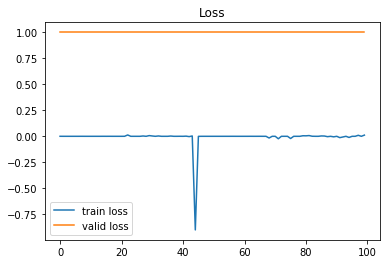

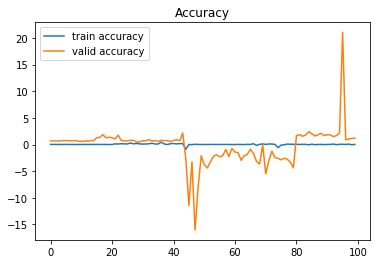

In [12]:
import matplotlib.pyplot as plt


train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]

train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()